**Notebook Objective**: 

Simple approach to build a sincere/insincere classifier for Quora questions.

- **Data preprocssing**
   
   Data Exploration: few statistics about the questions text.
   
   Building the vocabulary and then tokenizing the questions text.
    


- **Modelisation**
    
    Straight-forward Many-to-One approach with a LSTM layer. LSTM are particular RNN that prevent vanishing gradient and helps the model to better 'remember' when dealing with long sequences. For a better understanding of what is going on under the hood see: [Understanding LSTM](http://colah.github.io/posts/2015-08-Understanding-LSTMs/).
    
    We fed the model with embedded words. In this notebook we will use our own embeddings (trained on the top of the model) rather than the pre-trained ones given as auxiliary inputs. Despite an additional training step for our model, the idea here is that our embedding will be more dedicated to the specific task we are doing than a pre-trained embedding coming from Wikipedia pages.
    
    
- **Predictions and submission**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import tensorflow as tf
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.layers import Dense, Embedding, Dropout, LSTM
from keras import Model
from keras.optimizers import Adam  
import keras.backend as K
from keras.callbacks import Callback


Using TensorFlow backend.


# Data Exploration and Processing

In this section we will explore and make some preprocessing on the data to feed our model.

In [2]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")
print("Train shape : ", train.shape)
print("Test shape : ", test.shape)
train.head()

Train shape :  (1306122, 3)
Test shape :  (375806, 2)


,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [3]:
# Look at the classes distribution.
train.describe()

,target
count,1.306122e+06
mean,6.187018e-02
std,2.409197e-01
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,1.000000e+00


We can see that we have unbalanced classes: 6.2% insincere vs 93.8% sincere questions. Hence, the performance metrics can't be the accuracy, we will look at the F1-score (as mentioned in the challenge description).

## Some statistics

Min questions lenght: 1
Max questions lenght: 134
Mean questions lenght: 12.803609463740754
Standard deviation questions lenght: 7.052434330971179


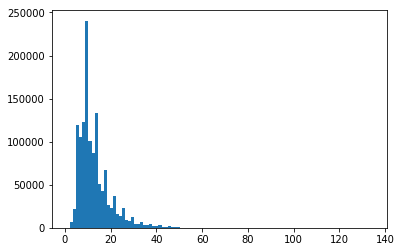

In [4]:
train['lenght_sentence'] = train['question_text'].apply(lambda x: len(x.split()))
print('Min questions lenght:', np.min(train['lenght_sentence'] ))
print('Max questions lenght:', np.max(train['lenght_sentence'] ))
print('Mean questions lenght:', np.mean(train['lenght_sentence'] ))
print('Standard deviation questions lenght:', np.std(train['lenght_sentence'] ))


# Plot the distribution of the lenght of the questions
plt.hist(train['lenght_sentence'], 100);

Min questions lenght: 1
Max questions lenght: 87
Mean questions lenght: 12.81084123191221
Standard deviation questions lenght: 7.04485108423754


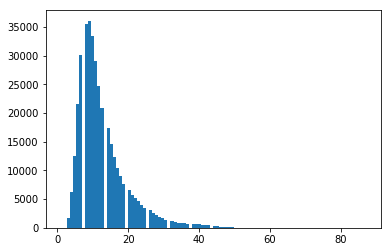

In [5]:
test['lenght_sentence'] = test['question_text'].apply(lambda x: len(x.split()))
print('Min questions lenght:', np.min(test['lenght_sentence'] ))
print('Max questions lenght:', np.max(test['lenght_sentence'] ))
print('Mean questions lenght:', np.mean(test['lenght_sentence'] ))
print('Standard deviation questions lenght:', np.std(test['lenght_sentence'] ))

# Plot the distribution of the lenght of the questions
plt.hist(test['lenght_sentence'], 100);

All the sentences are not of the same size, and we need them to be all at the same format to feed them to our model. 

To cope with this issue we will truncate too long sentences and use a 0 padding for the short sentences. Thanks to the statistics we have extracted we will use a max_sentence_length = 20 (mean+stddev).

## Building the vocabulary

We are going to build a vocabulary of all the unique words in the Train and Test sets. 

In [6]:
# First let's lower all the words in our train and test sets
train['question_text_truncated'] = train['question_text'].apply(lambda x: " ".join([word.lower() for word in x.split()[:20]]))
test['question_text_truncated'] = test['question_text'].apply(lambda x: " ".join([word.lower() for word in x.split()[:20]]))

train.head()

,qid,question_text,target,lenght_sentence,question_text_truncated
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,13,how did quebec nationalists see their province...
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,16,"do you have an adopted dog, how would you enco..."
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,10,why does velocity affect time? does velocity a...
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,9,how did otto von guericke used the magdeburg h...
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,15,can i convert montra helicon d to a mountain b...


In [7]:
# Add all the questions
list_questions = list(train['question_text_truncated']) + list(test['question_text_truncated'])

# Split the questions into words then join them all together and finally we remove duplicates
unique_words = set((" ".join(list_questions)).split())

In [8]:
# Give an index to each word staring from 2.
index_from = 2

# Making the vocabulary
vocabulary = {k: (v + index_from) for v, k in enumerate(unique_words)}

vocabulary["<PAD>"] = 0
vocabulary["<START>"] = 1

In [9]:
vocabulary

{'orthotolidine?': 2,
 'wellness/lifestyle': 3,
 'special"': 4,
 '"hatiyar"': 5,
 'syndactyly.': 6,
 'rope/reedfish': 7,
 'mno2?': 8,
 'redbubble': 9,
 '"tsurupika': 10,
 'phd-electrical': 11,
 'pacifism': 12,
 'cessation': 13,
 'diagrams,': 14,
 'khalifa?': 15,
 '2nights': 16,
 'schizophrenia,': 17,
 'r03': 18,
 'placement.?': 19,
 'bertoli': 20,
 'demodulate': 21,
 'expirstion': 22,
 'accommodate?': 23,
 'i18n': 24,
 'scrach': 25,
 'hospital/treatment': 26,
 'relativization': 27,
 'william,': 28,
 'crisper': 29,
 'overbite.': 30,
 'navigation?': 31,
 'qishan,': 32,
 'ias…i': 33,
 'phenergan?': 34,
 '51.': 35,
 'drinking/smoking': 36,
 "assis'": 37,
 'ozforex': 38,
 'punjabees?': 39,
 'danaans': 40,
 'love.': 41,
 'spectroscope)': 42,
 'c.s.': 43,
 'is/means': 44,
 'over-taxation?': 45,
 '(nothing,': 46,
 '"300"?': 47,
 'computers,': 48,
 'communty': 49,
 "'dangal'": 50,
 '64-bits': 51,
 'wholeheartedly': 52,
 'decomposed?': 53,
 'scet': 54,
 '“this': 55,
 '2^x-2^(-x)': 56,
 'cleartri

In [10]:
print('Vocabulary length:', len(vocabulary))

Vocabulary length: 497852


## Tokenization of the questions

Now that we have our vocabulary, we will tokenize our sentences and pad with 0 the smaller ones to reach a 134 sequence size.

In [11]:
# Tokenization of all words in a sentence using our vocabulary
def sentence_tokenization(sentence, vocabulary):
    tokenized_sentence = []
    for word in sentence.split():
        tokenized_sentence.append(vocabulary[word])
    return  tokenized_sentence
    

train["question_tokenized"] = train["question_text_truncated"].apply(lambda x: sentence_tokenization(x, vocabulary))
test["question_tokenized"] = test["question_text_truncated"].apply(lambda x: sentence_tokenization(x, vocabulary))
train.head()

,qid,question_text,target,lenght_sentence,question_text_truncated,question_tokenized
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,13,how did quebec nationalists see their province...,"[407716, 413381, 43056, 256481, 405959, 273237..."
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,16,"do you have an adopted dog, how would you enco...","[354193, 316362, 423148, 140019, 177645, 60715..."
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,10,why does velocity affect time? does velocity a...,"[119044, 358720, 490330, 268179, 15699, 358720..."
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,9,how did otto von guericke used the magdeburg h...,"[407716, 413381, 434631, 381917, 247766, 85088..."
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,15,can i convert montra helicon d to a mountain b...,"[446096, 113851, 452152, 268495, 45502, 60160,..."


In [12]:
input_max_length = 20
# 0 padding of the tokenized questions
X = sequence.pad_sequences(train['question_tokenized'], maxlen = input_max_length, padding = "post", truncating= "post", value = 0)
X_test = sequence.pad_sequences(test['question_tokenized'], maxlen = input_max_length, padding = "post", truncating= "post", value = 0)

y = train['target']

In [ ]:
# We prepare our data for the training and validation steps which we will make to avoid overfitting
# Train/Validate split is less time consuming than several folds cross-validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelisation: Many-to-One model with LSTM layer and Embedding on top

In [13]:
embedding_vector_length = 150
total_words = len(vocabulary) 
inputs_max_length = 20

model = Sequential()
model.add(Embedding(total_words, embedding_vector_length, input_length = inputs_max_length))
model.add(LSTM(units = 256))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 150)           74677800  
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               416768    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 75,094,825
Trainable params: 75,094,825
Non-trainable params: 0
_________________________________________________________________
None


We can see above that the Embedding task gathers about 99% of our total number of parameters!

In [14]:
# We must build a custom F1 metrics to plug it into our training steps with Keras
def f1(y_true, y_pred):
    '''
    metric from here 
    https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras
    '''
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
# Compile and fit the model on our Train/Validate datasets

#model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=[f1])
#model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_val, y_val))

In [17]:
# Training on the whole dataset
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=[f1])
model.fit(X, y, epochs=3, batch_size=64)

Instructions for updating:
Use tf.cast instead.
Epoch 1/3
1306122/1306122 [==============================] - 1077s 824us/step - loss: 0.1230 - f1: 0.4914
Epoch 2/3
1306122/1306122 [==============================] - 1060s 812us/step - loss: 0.0936 - f1: 0.6337
Epoch 3/3
1306122/1306122 [==============================] - 1054s 807us/step - loss: 0.0749 - f1: 0.7118


# Predictions and submission

In [18]:
pred_test = np.where(model.predict(X_test, batch_size=1024) < 0.5, 0, 1)

In [21]:

predictions = pd.DataFrame({"qid":test["qid"].values})
predictions['prediction'] = pred_test
predictions.head()

,qid,prediction
0,0000163e3ea7c7a74cd7,1
1,00002bd4fb5d505b9161,0
2,00007756b4a147d2b0b3,0
3,000086e4b7e1c7146103,0
4,0000c4c3fbe8785a3090,0


In [22]:
predictions.to_csv('submission.csv', index=False, sep=',')